In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [6]:
data = pd.read_csv("/Users/yangzedong/Desktop/Glasgow/mechine learning/Japan earthquakes 2001 - 2018.csv")

# time step
data["time"] = pd.to_datetime(data["time"])
data.sort_values(by="time", inplace=True)
data["year"] = data["time"].dt.year
data["month"] = data["time"].dt.month
data.shape

(14092, 24)

In [4]:
import plotly.express as px
fig=px.scatter(data, x="time", y="mag")
fig.update_layout(title='Earthquakes')
fig.show()

In [5]:
selected_features = [
    "year",
    "month",
    "depth",
    "mag",
    "gap",   
    "nst",    
    "magNst"  
]
valid_features = [col for col in selected_features if col in data.columns]
if len(valid_features) < len(selected_features):
    missing = set(selected_features) - set(valid_features)
    print(f"警告：以下特征在数据中不存在，将被移除: {missing}")
selected_features = valid_features


targets = ["latitude", "longitude"]
data= data[data["mag"] > 5.5]


In [6]:
data.shape

(767, 24)

In [7]:
data.isnull().sum()

time                 0
latitude             0
longitude            0
depth                0
mag                  0
magType              0
nst                136
gap                 58
dmin               632
rms                  2
net                  0
id                   0
updated              0
place                0
type                 0
horizontalError    654
depthError         456
magError           722
magNst             600
status               0
locationSource       0
magSource            0
year                 0
month                0
dtype: int64

In [8]:
import plotly.express as px
fig=px.scatter(data, x="time", y="mag")
fig.update_layout(title='Earthquakes')
fig.show()

In [9]:

data_clean = data.dropna(subset=selected_features + targets)

In [10]:
data_clean.shape

(121, 24)

In [23]:
X = data_clean[selected_features]
y = data_clean[targets]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, 
    y, 
    test_size=0.2, 
    random_state=42
)

In [12]:
#  RandomForest 
rf_model = RandomForestRegressor(random_state=42)

param_grid_rf = {
    "n_estimators": [100, 1000],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5]
}

rf_search = GridSearchCV(rf_model, param_grid_rf, cv=3, scoring="neg_mean_squared_error", verbose=1)
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_

y_pred_rf = best_rf.predict(X_test)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)
# cross validation
scores = cross_val_score(rf_model, X_train, y_train, cv=10, scoring="neg_mean_squared_error")
print("Cross-Validation Scores:", -scores)  # 负值转为正值
print("Average MSE:", -scores.mean())
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

Cross-Validation Scores: [ 4.96493911  1.86815011  0.97486361  1.71995773 19.70611815  1.75057711
  1.82478704  0.93972812  1.46582419  1.10513702]
Average MSE: 3.632008217892558


In [14]:
#XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)


In [15]:
# MLP
nn_model = MLPRegressor(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42
)
nn_model.fit(X_train, y_train)
y_pred_nn = nn_model.predict(X_test)

/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.



In [16]:
 
def evaluate_model(y_true, y_pred, model_name=""):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

print("=== Evaluation Results ===")
evaluate_model(y_test, y_pred_rf,  "RandomForest (Tuned)")
evaluate_model(y_test, y_pred_xgb, "XGBoost")
evaluate_model(y_test, y_pred_nn,  "MLP NeuralNetwork")

=== Evaluation Results ===
RandomForest (Tuned) - MAE: 0.8057, MSE: 0.9811, RMSE: 0.9905, R²: 0.9189
XGBoost - MAE: 0.9231, MSE: 1.8987, RMSE: 1.3779, R²: 0.8607
MLP NeuralNetwork - MAE: 9.2019, MSE: 162.3401, RMSE: 12.7413, R²: -9.3391


In [17]:

def visualize_scatter_geo(data_frame, title="Earthquake Locations"):
    fig = px.scatter_geo(
        data_frame=data_frame,
        lat="latitude",
        lon="longitude",
        scope="world",
        color="type",
        hover_name="type",
        title=title
    )
    fig.show()

y_test_cp = y_test.copy()
y_test_cp["type"] = "actual"

pred_rf_df = pd.DataFrame(y_pred_rf, columns=["latitude", "longitude"])
pred_rf_df["type"] = "rf_pred"

pred_xgb_df = pd.DataFrame(y_pred_xgb, columns=["latitude", "longitude"])
pred_xgb_df["type"] = "xgb_pred"

pred_nn_df = pd.DataFrame(y_pred_nn, columns=["latitude", "longitude"])
pred_nn_df["type"] = "nn_pred"

vis_data = pd.concat([y_test_cp, pred_rf_df, pred_xgb_df, pred_nn_df])
visualize_scatter_geo(vis_data, "Actual vs Predicted Earthquake Locations")


/var/folders/w2/_1tnpyv54znf28ppq1jgwnzr0000gn/T/ipykernel_6940/4214392300.py:6: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/var/folders/w2/_1tnpyv54znf28ppq1jgwnzr0000gn/T/ipykernel_6940/4214392300.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




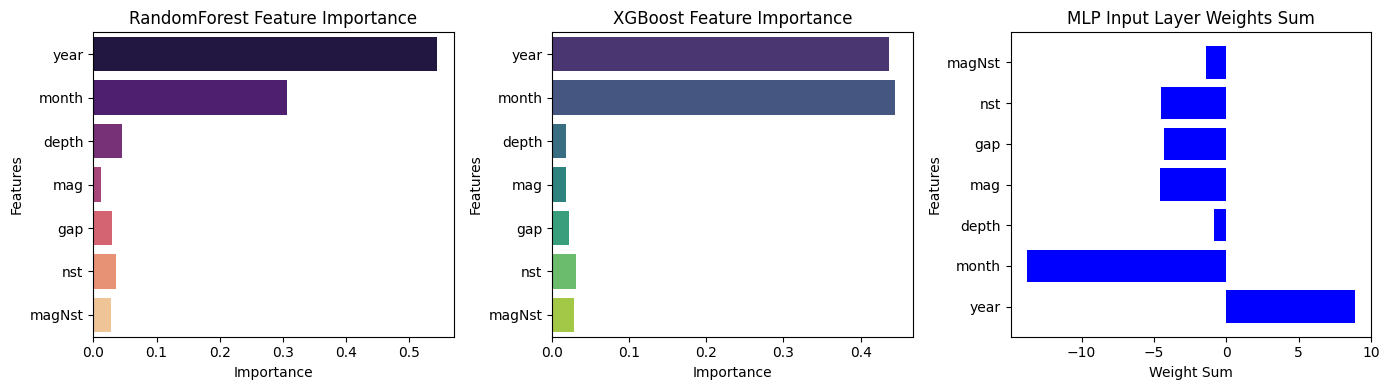

In [18]:
# RandomForest 
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
importances_rf = best_rf.feature_importances_
sns.barplot(x=importances_rf, y=selected_features, palette="magma")
plt.title("RandomForest Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")

# XGBoost
plt.subplot(1, 3, 2)
importances_xgb = xgb_model.feature_importances_
sns.barplot(x=importances_xgb, y=selected_features, palette="viridis")
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")

# MLP 
plt.subplot(1, 3, 3)
nn_weights = nn_model.coefs_[0].sum(axis=1)  
plt.barh(selected_features, nn_weights, color="blue")
plt.title("MLP Input Layer Weights Sum")
plt.xlabel("Weight Sum")
plt.ylabel("Features")

plt.tight_layout()
plt.show()


In [19]:
import folium
def visualize_with_folium(data_frame, title="Earthquake Locations"):
    
    eq_map = folium.Map(location=[36, 135], tiles='OpenStreetMap', zoom_start=4.0, min_zoom=2.0)

   
    color_dict = {
        "actual": "blue",
        "rf_pred": "red",
        "xgb_pred": "green",
        "nn_pred": "purple"
    }

    
    for _, row in data_frame.iterrows():
        folium.CircleMarker(
            location=[row["latitude"], row["longitude"]],
            radius=3,  
            color=color_dict.get(row["type"], "gray"),
            fill=True,
            fill_color=color_dict.get(row["type"], "gray"),
            fill_opacity=0.7,
            popup=f"{row['type']} ({row['latitude']:.2f}, {row['longitude']:.2f})"
        ).add_to(eq_map)

   
    legend_html = """
    <div style="position: fixed; bottom: 20px; left: 20px; background-color: white; z-index:9999; padding: 10px; font-size: 14px;">
        <b>Legend</b><br>
        <span style="color: blue;">●</span> Actual<br>
        <span style="color: red;">●</span> RandomForest Prediction<br>
        <span style="color: green;">●</span> XGBoost Prediction<br>
        <span style="color: purple;">●</span> MLP Neural Network Prediction<br>
    </div>
    """
    eq_map.get_root().html.add_child(folium.Element(legend_html))

    return eq_map


y_test_cp = y_test.copy()
y_test_cp["type"] = "actual"

pred_rf_df = pd.DataFrame(y_pred_rf, columns=["latitude", "longitude"])
pred_rf_df["type"] = "rf_pred"

pred_xgb_df = pd.DataFrame(y_pred_xgb, columns=["latitude", "longitude"])
pred_xgb_df["type"] = "xgb_pred"

pred_nn_df = pd.DataFrame(y_pred_nn, columns=["latitude", "longitude"])
pred_nn_df["type"] = "nn_pred"
vis_data = pd.concat([y_test_cp, pred_rf_df, pred_xgb_df, pred_nn_df])
eq_map = visualize_with_folium(vis_data, "Actual vs Predicted Earthquake Locations")
eq_map

In [20]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor


rf_model = RandomForestRegressor(random_state=42)


param_grid_rf = {
    "n_estimators": [50, 100, 200, 500, 1000],
    "max_depth": [None, 5, 10, 15, 20, 30],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4, 10],
    "max_features": ["auto", "sqrt", "log2"],
    "bootstrap": [True, False]
}


rf_search = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring="neg_mean_squared_error", verbose=1)
rf_search.fit(X_train, y_train)


best_rf = rf_search.best_estimator_
print("Best Parameters:", rf_search.best_params_)


y_pred_rf = best_rf.predict(X_test)

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits


KeyboardInterrupt: 

In [ ]:
rmse_rf = np.sqrt(mse_rf)
print(f"Random Forest RMSE: {rmse_rf:.4f}")

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint


rf_model = RandomForestRegressor(random_state=42)


param_dist_rf = {
    "n_estimators": randint(50, 1001),  # 从50到1000之间选择
    "max_depth": [None, 5, 10, 15, 20, 30],
    "min_samples_split": randint(2, 21),
    "min_samples_leaf": randint(1, 21),
    "max_features": ["auto", "sqrt", "log2"],
    "bootstrap": [True, False]
}


rf_search = RandomizedSearchCV(rf_model, param_distributions=param_dist_rf, n_iter=100, cv=5, 
                               scoring="neg_mean_squared_error", random_state=42, verbose=1, n_jobs=-1)
rf_search.fit(X_train, y_train)

# 输出最佳参数
best_rf = rf_search.best_estimator_
print("Best Parameters:", rf_search.best_params_)

# 在测试集上进行预测
y_pred_rf = best_rf.predict(X_test)

In [ ]:

mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
print(f"Random Forest MSE: {mse_rf:.4f}")
print(f"Random Forest RMSE: {rmse_rf:.4f}")

In [ ]:
from sklearn.neural_network import MLPRegressor

nn_model = MLPRegressor(
    hidden_layer_sizes=(200, 100, 50),  
    activation='relu',
    solver='adam',
    max_iter=1000,  
    learning_rate_init=0.001, 
    alpha=0.0001,  
    random_state=42,
    early_stopping=True,  
    validation_fraction=0.1,  
    n_iter_no_change=10  
)

# train
nn_model.fit(X_train, y_train)

# predict
y_pred_nn = nn_model.predict(X_test)

def evaluate_model(y_true, y_pred, model_name=""):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

print("=== Evaluation Results ===")
evaluate_model(y_test, y_pred_nn, "MLP NeuralNetwork")

=== Evaluation Results ===
MLP NeuralNetwork - MAE: 3.2313, MSE: 21.6884, RMSE: 4.6571, R²: -0.4402


/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.



In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

data = pd.read_csv("/Users/yangzedong/Desktop/Glasgow/mechine learning/Japan earthquakes 2001 - 2018.csv")

data["time"] = pd.to_datetime(data["time"])
data.sort_values(by="time", inplace=True)
data["year"] = data["time"].dt.year
data["month"] = data["time"].dt.month
data["day"] = data["time"].dt.day
data["hour"] = data["time"].dt.hour
data["minute"] = data["time"].dt.minute
selected_features = ["year", "month", "day", "hour", "minute", "depth", "gap", "nst", "magNst"]
targets = ["latitude", "longitude", "mag"]
data = data[data["mag"] > 5.5]
data_clean = data.dropna(subset=selected_features + targets)
X = data_clean[selected_features]
y = data_clean[targets]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)


rf_model = RandomForestRegressor(random_state=42)
param_grid_rf = {
    "n_estimators": [100, 500],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5]
}
rf_search = GridSearchCV(rf_model, param_grid_rf, cv=3, scoring="neg_mean_squared_error", verbose=1)
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_
y_pred_rf = best_rf.predict(X_test)


mae = mean_absolute_error(y_test, y_pred_rf)
mse = mean_squared_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R2 Score: {r2}")

fig = px.scatter(
    x=y_test["longitude"], y=y_test["latitude"], color=y_test["mag"],
    labels={"x": "Longitude", "y": "Latitude", "color": "Magnitude"},
    title="Actual Earthquake Locations with Magnitude"
)
fig.add_trace(px.scatter(
    x=y_pred_rf[:, 1], y=y_pred_rf[:, 0], color=y_test["mag"],
    labels={"x": "Longitude", "y": "Latitude", "color": "Magnitude"}
).data[0])
fig.show()


Fitting 3 folds for each of 12 candidates, totalling 36 fits
MAE: 0.6411522940276724
MSE: 0.835045065140945
R2 Score: 0.6792112325770395


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

data = pd.read_csv("/Users/yangzedong/Desktop/Glasgow/mechine learning/Japan earthquakes 2001 - 2018.csv")
data["time"] = pd.to_datetime(data["time"])
data.sort_values(by="time", inplace=True)
data["year"] = data["time"].dt.year
data["month"] = data["time"].dt.month
data["day"] = data["time"].dt.day
data["hour"] = data["time"].dt.hour
data["minute"] = data["time"].dt.minute


selected_features = ["year", "month", "day", "hour", "minute", "depth", "gap", "nst", "magNst"]
targets = ["latitude", "longitude", "mag"]


data = data[data["mag"] > 5.5]


data_clean = data.dropna(subset=selected_features + targets)


X = data_clean[selected_features]
y = data_clean[targets]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

rf_model = RandomForestRegressor(random_state=42)
param_grid_rf = {
    "n_estimators": [100, 500],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5]
}
rf_search = GridSearchCV(rf_model, param_grid_rf, cv=3, scoring="neg_mean_squared_error", verbose=1)
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_


y_pred_rf = best_rf.predict(X_test)


mae = mean_absolute_error(y_test, y_pred_rf)
mse = mean_squared_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R2 Score: {r2}")

def visualize_with_folium(actual_df, pred_df):
    eq_map = folium.Map(location=[36, 135], tiles='OpenStreetMap', zoom_start=4.0, min_zoom=2.0)
    
    for _, row in actual_df.iterrows():
        folium.CircleMarker(
            location=[row["latitude"], row["longitude"]],
            radius=row["mag"] * 2,
            color="blue",
            fill=True,
            fill_color="blue",
            fill_opacity=0.6,
            popup=f"Actual: Mag {row['mag']:.2f}"
        ).add_to(eq_map)
    
    for _, row in pred_df.iterrows():
        folium.CircleMarker(
            location=[row["latitude"], row["longitude"]],
            radius=3,
            color="red",
            fill=True,
            fill_color="red",
            fill_opacity=0.6,
            popup="Predicted"
        ).add_to(eq_map)
    
    return eq_map

actual_df = y_test.copy()
pred_df = pd.DataFrame(y_pred_rf, columns=["latitude", "longitude", "mag"])[["latitude", "longitude"]]
eq_map = visualize_with_folium(actual_df, pred_df)
eq_map.save("earthquake_predictions.html")



Fitting 3 folds for each of 12 candidates, totalling 36 fits
MAE: 0.6411522940276724
MSE: 0.835045065140945
R2 Score: 0.6792112325770395


In [29]:
eq_map